# AutoGluon Fit Backend Tutorial

## Prerequisite
Please read **autogluon_demo Tutorial** first, if not yet.

## Install AutoGluon

```
cd AutoGluon && python setup.py install
```

## Understanding Task, Resource and Scheduler

<img src="img/scheduler.png" alt="Overlook" style="width: 600px;"/>

Resources contains number of cpus and gpus. Task includes execute function, args and its resource. TaskScheduler automatically request resource for tasks and execut it as soon as its resource is ready.

In [1]:
from autogluon.resource import Resources
from autogluon.scheduler import Task, TaskScheduler
import time

**Define custimized task**

In [2]:
def my_task():
    print('running, my_task')
    time.sleep(3.0)


**Create scheduler**

In [3]:
scheduler = TaskScheduler()

Add tasks with their resources to scheduler

In [4]:
for i in range(5):
    resource = Resources(num_cpus=2, num_gpus=0)
    task = Task(my_task, {}, resource)
    scheduler.add_task(task)

running, my_task
running, my_task
running, my_task
running, my_task
running, my_task


## Launch Task with Different Configurations

In [5]:
import autogluon as ag
from autogluon import autogluon_method

**Configuration handled by `autogluon_method`**

In [6]:
@autogluon_method
def train_fn(args):
    print('lr is {}'.format(args.lr))
    
import argparse
import numpy as np
args = argparse.ArgumentParser()
config = {'lr': ag.searcher.sample_from(
          lambda: np.power(10.0, np.random.uniform(-4, -1)))}

**Schedule Tasks**

In [7]:
myscheduler = TaskScheduler()
for i in range(5):
    resource = Resources(num_cpus=2, num_gpus=0)
    task = Task(train_fn, {'args': args, 'config': config}, resource)
    myscheduler.add_task(task)

lr is 0.001782649715138694
lr is 0.07963234721775593
lr is 0.00203228544324115
lr is 0.0044915238251379995
lr is 0.00046342505832948756


## Search Algorithm and Trial Scheduler

Search Algorithm observes the performance of each task and suggests set of hyper parameters for each new task based on the history information.
<img src="img/scheduler_searcher.png" alt="Searcher" style="width: 600px;"/>
**Construct `autogluon_method` with reporter**

In [8]:
@autogluon_method
def train_fn(args, reporter):
    for e in range(10):
        # forward, backward, optimizer step and evaluation metric
        # generate fake top1_accuracy
        top1_accuracy = 1 - np.power(1.8, -np.random.uniform(e, 2*e))
        reporter(epoch=e, accuracy=top1_accuracy)

**Create hyperparameter configuration space and construct `searcher` from the configuration space**

In [9]:
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH

cs = CS.ConfigurationSpace()
lr = CSH.UniformFloatHyperparameter('lr', lower=1e-4, upper=1e-1, log=True)
cs.add_hyperparameter(lr)

searcher = ag.searcher.RandomSampling(cs)

**Use Hyperband Scheduler or FIFO scheduler**

Scheduler monitors the training progress of each task and apply early termination if needed.

In [10]:
myscheduler = ag.scheduler.Hyperband_Scheduler(train_fn, args,
                                               resource={'num_cpus': 2, 'num_gpus': 0}, 
                                               searcher=searcher, num_trials=20,
                                               reward_attr='accuracy',
                                               time_attr='epoch',
                                               grace_period=1)
# run tasks
myscheduler.run()

**Join Tasks and Plot Results**

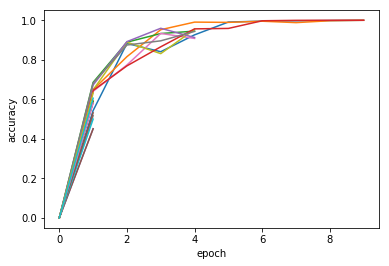

In [11]:
myscheduler.join_tasks()
myscheduler.get_training_curves(plot=True, use_legend=False)

You may get Tensorboard Visualization:
``tensorboard --logdir=./tutorials/exp/checkerpoint/logs/ --host=127.0.0.1 --port=8887``

<img src="img/backend_demo.jpg" alt="Backend Demo" style="width: 600px;"/>


## Add You Own Searcher

In [12]:
from autogluon.searcher import BaseSearcher
class MyRandomSampling(BaseSearcher):
    """Random sampling Searcher for ConfigSpace
    """
    def __init__(self, configspace):
        super(MyRandomSampling, self).__init__(configspace)
        # you may save and update state for your own algorithm
        self.mystate = {}
        
    def get_config(self):
        """Function to sample a new configuration
        """
        # get configuration space
        cs = self.configspace
        # sample the configuration using random sampling
        myconfig = cs.sample_configuration()
        # return the dictionary format
        return myconfig.get_dictionary()

    def update(self, config, reward, mystate):
        """Update the searcher with the newest metric report
        """
        # we automatically track the history results in self._results
        super(MyRandomSampling, self).update(config, reward)
        # you may save and update state for your own algorithm
        self.mystate[config] = mystate

## Add Your Own Task Scheduler

In [13]:
import collections
import numpy as np
import multiprocessing as mp
from autogluon.scheduler import Hyperband_Scheduler


class MedianStopping_Scheduler(Hyperband_Scheduler):
    def __init__(self, train_fn, args, resource, searcher,
                 checkpoint='./exp/checkerpoint.ag', 
                 resume=False,
                 num_trials=None,
                 time_attr="training_epoch",
                 reward_attr="accuracy",
                 visualizer='tensorboard',
                 mode="max",
                 grace_period=1.0,
                 min_samples_required=3):
        super(MedianStopping_Scheduler, self).__init__(train_fn, args, resource, searcher,
                                                       checkpoint, resume, num_trials,
                                                       time_attr, reward_attr, visualizer=visualizer)
        self.terminator = MediamStoppingRule(time_attr, reward_attr, mode, grace_period,
                                             min_samples_required)
    def state_dict(self, destination=None):
        pass

# This code is adapted from ray-project
class MediamStoppingRule(object):
    LOCK = mp.Lock()
    def __init__(self,
                 time_attr="training_epoch",
                 reward_attr="accuracy",
                 mode="max",
                 grace_period=1,
                 min_samples_required=3):
        self._time_attr = time_attr
        self._reward_attr = reward_attr
        self._stopped_tasks = set()
        self._completed_tasks = set()
        self._results = collections.defaultdict(list)
        self._grace_period = grace_period
        self._min_samples_required = min_samples_required
        self._metric = reward_attr
        if mode == "max":
            self._metric_op = 1.
        elif mode == "min":
            self._metric_op = -1.
 
    def on_task_add(self, task):
        pass
 
    def on_task_report(self, task, result):
        # return True/False, which indicates whether we want to continue
        time = result[self._time_attr]
        self._results[task].append(result)
        median_result = self._get_median_result(time)
        best_result = self._best_result(task)
 
        if best_result < median_result and time > self._grace_period:
            self._stopped_tasks.add(task)
            return False
        else:
            return True

    def on_task_complete(self, task, result):
        self._results[task].append(result)
        self._completed_tasks.add(task)

    def on_task_remove(self, task):
        if task in self._results:
            self._completed_tasks.add(task)

    def _get_median_result(self, time):
        scores = []
        for task in self._completed_tasks:
            scores.append(self._running_result(task, time))
        if len(scores) >= self._min_samples_required:
            return np.median(scores)
        else:
            return float("-inf")

    def _running_result(self, task, t_max=float("inf")):
        results = self._results[task]
        return np.max([self._metric_op * r[self._metric] 
                       for r in results if r[self._time_attr] <= t_max])

    def _best_result(self, task):
        results = self._results[task]
        return max(self._metric_op * r[self._metric] for r in results)

    def __repr__(self):
        return "MedianStoppingRule: num_stopped={}.".format(
            len(self._stopped_tasks))

In [14]:
@autogluon_method
def train_fn(args, reporter):
    for e in range(10):
        # forward, backward, optimizer step and evaluation metric
        # generate fake top1_accuracy
        top1_accuracy = 1 - np.power(1.8, -np.random.uniform(e, 2*e))
        if e % 10 == 0:
            reporter(epoch=e, accuracy=top1_accuracy)

In [15]:
myscheduler = MedianStopping_Scheduler(train_fn, args,
                                       resource={'num_cpus': 2, 'num_gpus': 0}, 
                                       searcher=searcher, num_trials=20,
                                       reward_attr='accuracy',
                                       time_attr='epoch',
                                       grace_period=1)
# run tasks
myscheduler.run()
myscheduler.join()

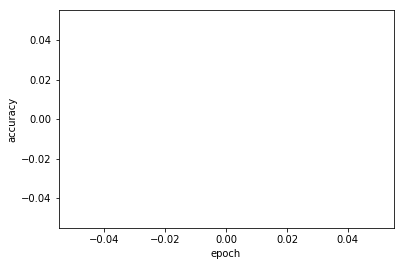

In [16]:
myscheduler.get_training_curves(plot=True, use_legend=False)